In [6]:
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (15,10)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
engine = sqlalchemy.create_engine(config.BUSD_DB_URL)
df = pd.read_sql(f'SELECT * from {config.BUSD_DB_PRICE_TABLE}', engine)

In [8]:
df.head()

,Symbol,Time,Open,High,Low,Close,Volume,Taker_buy_volume
0,BNBBUSD,2019-09-19 00:00:00.000000,21.2021,21.5998,20.7415,21.5998,2416.72,151.22
1,BNBBUSD,2019-09-20 00:00:00.000000,21.4918,21.5380,20.9728,21.2280,1014.81,689.47
2,BNBBUSD,2019-09-21 00:00:00.000000,21.3134,21.4138,20.8128,20.8755,35.59,24.60
3,BNBBUSD,2019-09-22 00:00:00.000000,20.7415,20.7415,20.0146,20.4181,198.81,105.99
4,BNBBUSD,2019-09-23 00:00:00.000000,20.3258,20.3258,19.2092,19.3267,804.23,384.79


<AxesSubplot:xlabel='Time'>

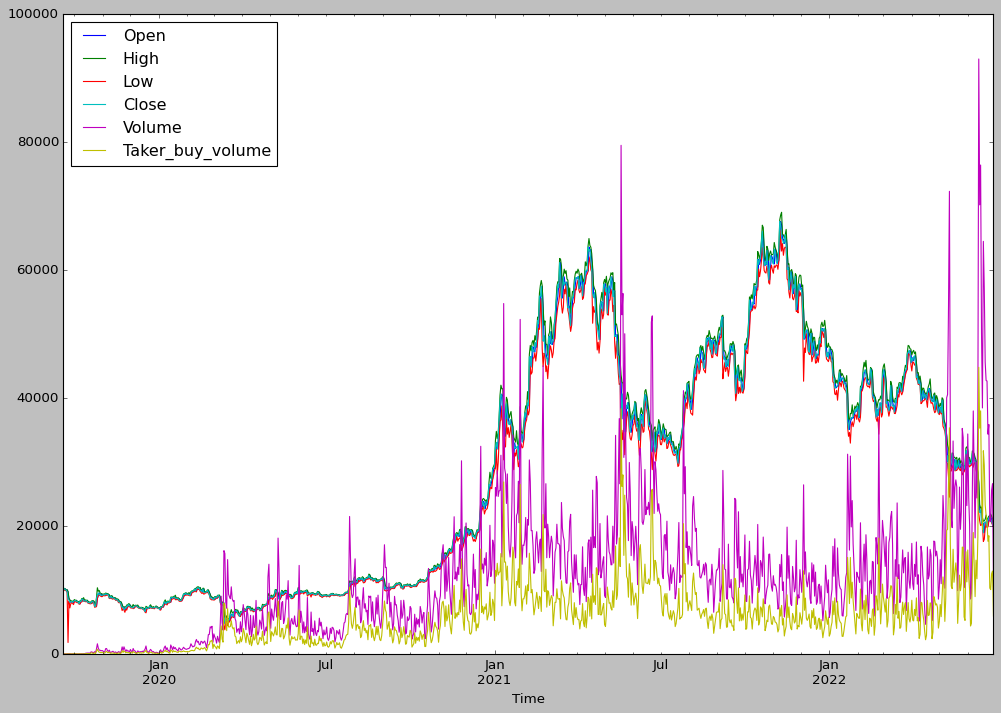

In [9]:
df.set_index(pd.to_datetime(df.Time)).query('Symbol == "BTCBUSD"').plot()

In [10]:
price_btc = df.set_index(pd.to_datetime(df.Time)).\
    query('Symbol == "BTCBUSD"')[['Volume','Close']]

In [11]:
dailyreturn = df[['Time','Symbol','Close']].\
    pivot(index='Time', columns='Symbol', values='Close').\
    dropna(axis=1).\
    pct_change()
dailyreturn.index = pd.to_datetime(dailyreturn.index)
dailyreturn

Symbol,BNBBUSD,BTCBUSD
Time,,
2019-09-19,NaN,NaN
2019-09-20,-0.017213,-0.008178
2019-09-21,-0.016605,-0.016929
2019-09-22,-0.021911,0.001166
2019-09-23,-0.053453,-0.030328
...,...,...
2022-06-25,-0.002499,0.012135
2022-06-26,-0.023382,-0.020941
2022-06-27,-0.001283,-0.014512


<AxesSubplot:xlabel='Time'>

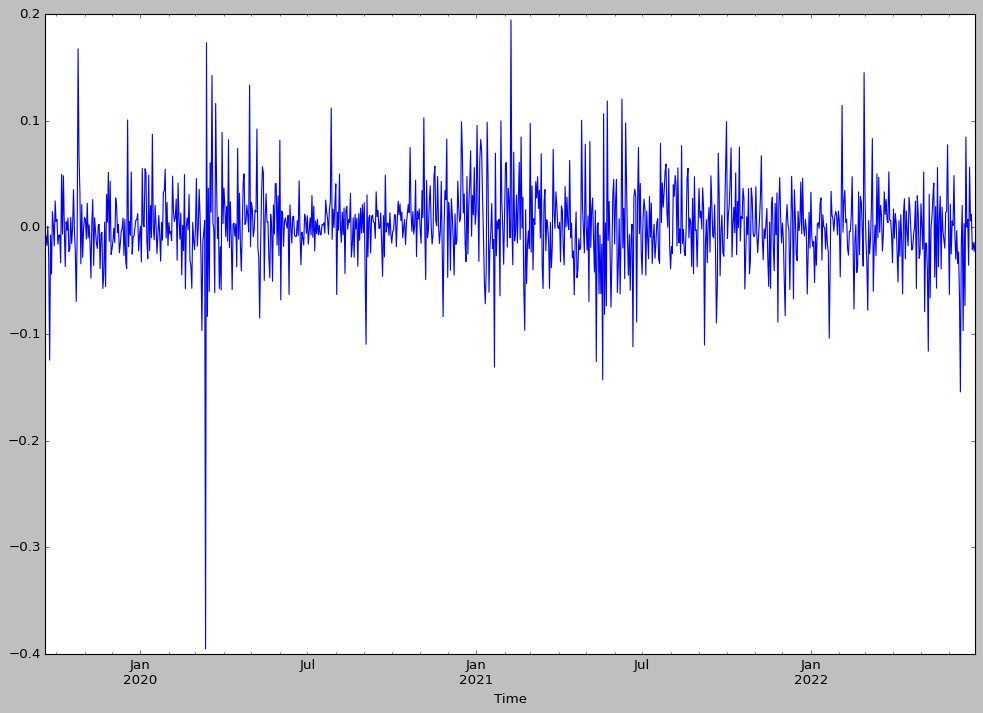

In [12]:
dailyreturn['BTCBUSD'].plot()

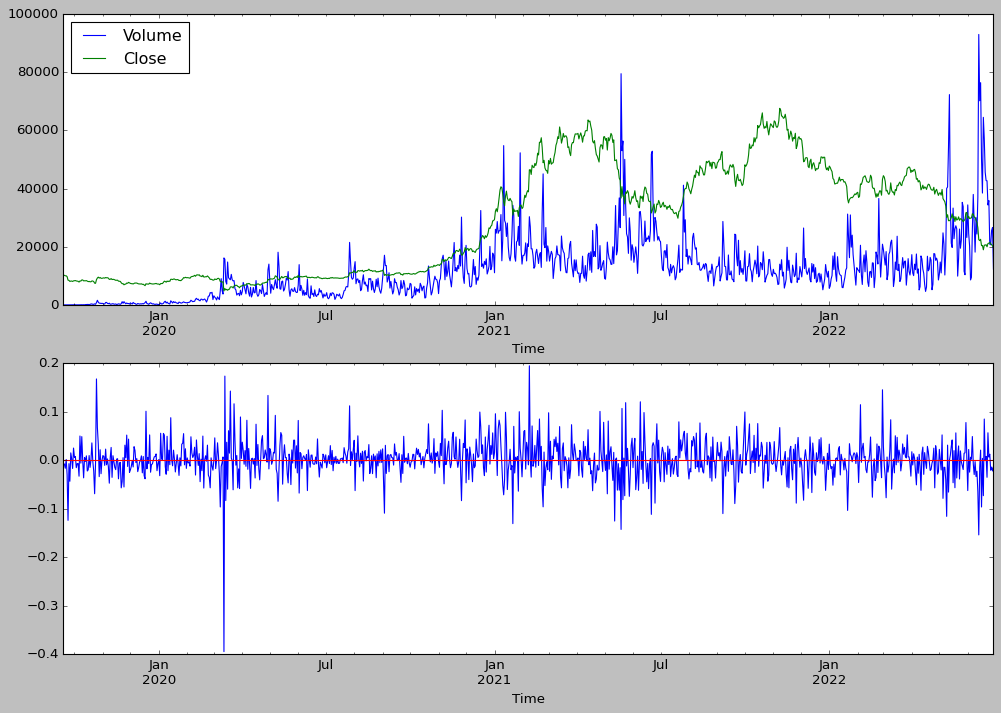

In [13]:
fig, axs = plt.subplots(2,1)
price_btc.plot(ax=axs[0])
dailyreturn['BTCBUSD'].plot(ax=axs[1])
axs[1].axhline(y=0, color='r')

# SMA cross over strategy
It is based on two smooth moving average(SMA) price value to create trading signals. If fast line is crossing above slow one, the buy signal is created. Vice versa to the sell signal. 

In [14]:
price_btc['close_sma10'] = price_btc['Close'].rolling(10).mean()
price_btc['close_sma20'] = price_btc['Close'].rolling(20).mean()
price_btc['close_sma50'] = price_btc['Close'].rolling(50).mean()
price_btc['volume_sma20'] = price_btc['Volume'].rolling(20).mean()

In [15]:
price_btc['c10_High'] = np.where(price_btc['close_sma10'] > price_btc['close_sma20'], 1, 0)
price_btc['signals'] = np.where((price_btc['c10_High'] - price_btc['c10_High'].shift(1)) == 1, 1, 0)
price_btc['signals'] = np.where((price_btc['c10_High'] - price_btc['c10_High'].shift(1)) == -1, -1, price_btc['signals'])

stoploss = 0.1
position = np.zeros(price_btc.shape[0])
for i in range(price_btc.shape[0]):
    if price_btc['signals'][i] == 1:
        position[i:] += 1
    if (price_btc['signals'][i] == -1) & (position[i] == 1):
        position[i:] -= 1

# Stop loss
#
price_btc['return'] = price_btc['Close'].pct_change()
price_btc['position'] = pd.Series(position, index=price_btc.index).shift(1)
price_btc['strategy_return'] = price_btc['return'] * price_btc['position']
# price_btc['sell_signals'] = np.where(price_btc['close_sma10'] < price_btc['close_sma20'], 1, 0)

In [16]:
price_btc.tail()

,Volume,Close,close_sma10,close_sma20,close_sma50,volume_sma20,c10_High,signals,return,position,strategy_return
Time,,,,,,,,,,,
2022-06-25,20839.68483,21476.51,20530.858,23956.694,27674.7324,43623.289420,0,0,0.012135,0.0,0.0
2022-06-26,20686.54742,21026.76,20596.229,23440.769,27385.9904,43378.913153,0,0,-0.020941,0.0,-0.0
2022-06-27,25597.06040,20721.63,20624.008,22921.429,27119.8560,42759.808713,0,0,-0.014512,0.0,-0.0
2022-06-28,26598.07438,20256.79,20755.418,22425.361,26923.4452,42703.758831,0,0,-0.022433,0.0,-0.0
2022-06-29,12317.55664,19974.70,20698.348,21919.968,26702.8704,42412.414587,0,0,-0.013926,0.0,-0.0


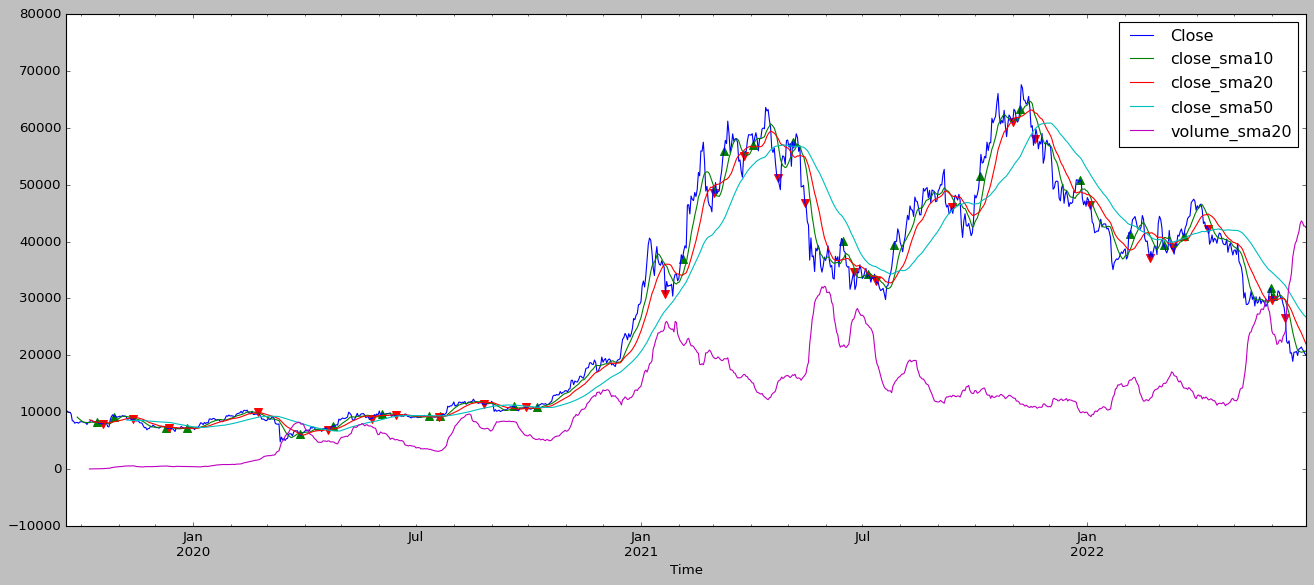

In [17]:
price_btc[['Close','close_sma10','close_sma20','close_sma50','volume_sma20']].plot(figsize=(20,8))
plt.scatter(price_btc.index[price_btc['signals'] == 1],\
     price_btc.loc[price_btc.index[price_btc['signals'] == 1]]['Close'],\
     marker='^',color=color_pal[color_pal.index('g')], s=50)
plt.scatter(price_btc.index[price_btc['signals'] == -1],\
     price_btc.loc[price_btc.index[price_btc['signals'] == -1]]['Close'],\
     marker='v',color=color_pal[color_pal.index('r')], s=50)

In [18]:
print(((price_btc['return']+1).cumprod()-1)[-1])
print(((price_btc['strategy_return']+1).cumprod()-1)[-1])

0.9478162677036885
2.4807140284999174


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Time'>

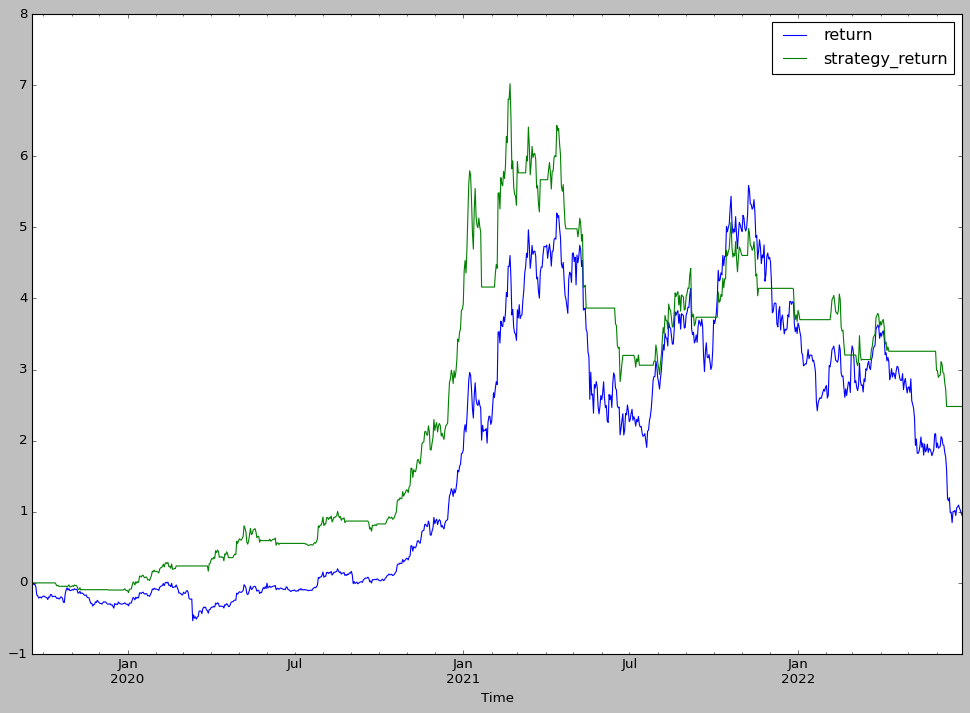

In [57]:
_, axs = plt.subplots(1,1)
((price_btc['return']+1).cumprod()-1).plot(ax=axs, legend='buy_hold')
((price_btc['strategy_return']+1).cumprod()-1).plot(ax=axs, legend='sma')

In [19]:
import vectorbt as vbt

price = price_btc['Close']
pf = vbt.Portfolio.from_holding(price, init_cash=100)
pf.total_profit()

94.78162677036974

In [21]:
fast_ma = vbt.MA.run(price, 10)
slow_ma = vbt.MA.run(price, 20)
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(price, entries, exits, init_cash=100)
pf.total_profit()

248.0714028499914

In [22]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [23]:
import backtrader as bt

In [32]:
class smaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=20)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)
    

Starting Portfolio Value: 100.00


<IPython.core.display.Javascript object>

Final Portfolio Value: 54.14


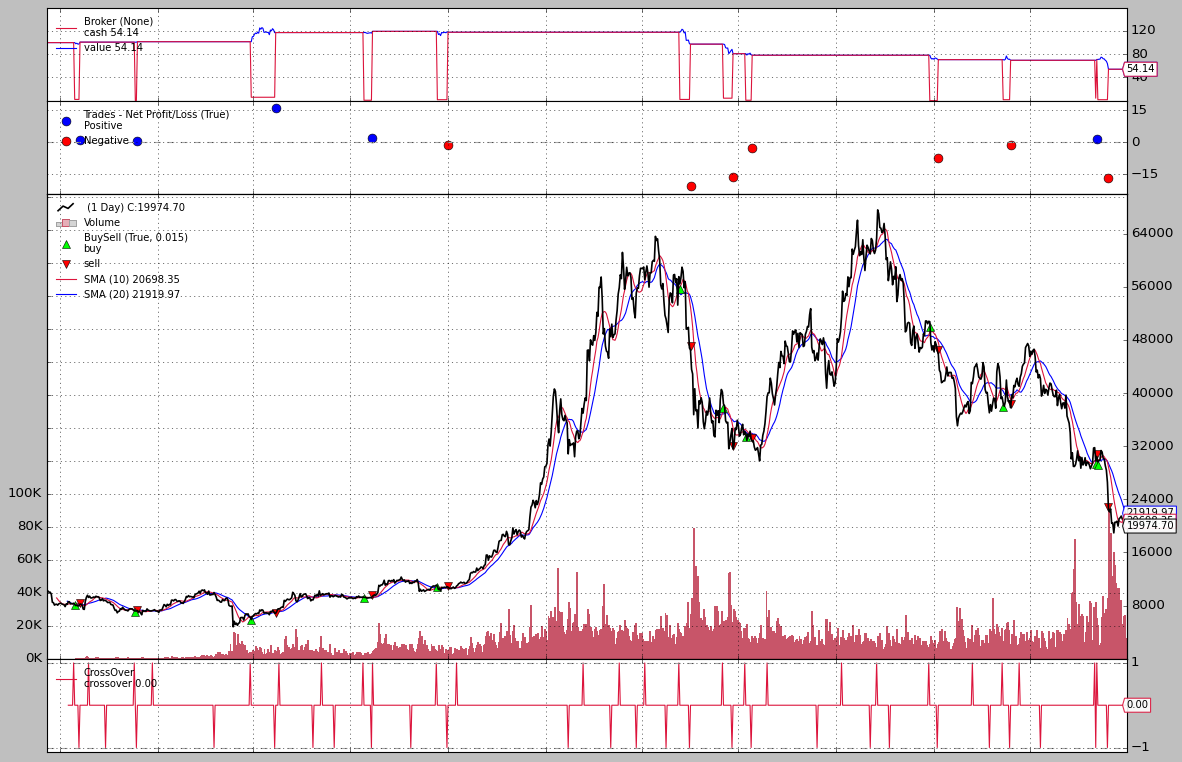

In [34]:
cerebro0 = bt.Cerebro()
cerebro0.addstrategy(smaCross)

cerebro0.adddata(bt.feeds.PandasData(dataname = price_btc[['Close', 'Volume']].iloc[:],\
     close='Close', volume='Volume', open='Close', high='Close', low='Close'))

cerebro0.broker.set_cash(100)
cerebro0.addsizer(bt.sizers.PercentSizer, percents=100)

print('Starting Portfolio Value: %.2f' % cerebro0.broker.get_value())
cerebro0.run()
cerebro0.plot()
print('Final Portfolio Value: %.2f' % cerebro0.broker.get_value())

In [25]:
class smaCro(bt.Strategy):
    params = dict(
        pfast=10,  
        pslow=20
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.params.pfast)
        sma2 = bt.ind.SMA(period=self.params.pslow)  
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash    

    def next(self):
        if not self.position:  
            if self.crossover > 0:
                self.buy()
                # self.log('Buy create: %.2f' % self.data.close[0])
        else:
            if self.crossover < 0:  
                self.sell()
                # self.log('Sell create: %.2f' % self.data.close[0])

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.5f, Cost: %.f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.5f, Cost: %.f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None    
        
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))    

Starting Portfolio Value: 100.00
2019-10-15, BUY EXECUTED, Price: 8163.65000, Cost: 93, Comm 0.00
2019-10-20, SELL EXECUTED, Price: 8232.05000, Cost: 93, Comm 0.00
2019-10-29, BUY EXECUTED, Price: 9420.66000, Cost: 98, Comm 0.00
2019-11-14, SELL EXECUTED, Price: 8629.52000, Cost: 98, Comm 0.00
2019-12-11, BUY EXECUTED, Price: 7194.36000, Cost: 88, Comm 0.00
2019-12-13, SELL EXECUTED, Price: 7248.97000, Cost: 88, Comm 0.00
2019-12-28, BUY EXECUTED, Price: 7292.62000, Cost: 89, Comm 0.00
2020-02-24, SELL EXECUTED, Price: 9654.97000, Cost: 89, Comm 0.00
2020-03-29, BUY EXECUTED, Price: 5883.13000, Cost: 109, Comm 0.00
2020-04-21, SELL EXECUTED, Price: 6850.65000, Cost: 109, Comm 0.00
2020-04-25, BUY EXECUTED, Price: 7545.92000, Cost: 134, Comm 0.00
2020-05-27, SELL EXECUTED, Price: 9202.59000, Cost: 134, Comm 0.00
2020-06-04, BUY EXECUTED, Price: 9791.63000, Cost: 163, Comm 0.00
2020-06-16, SELL EXECUTED, Price: 9525.19000, Cost: 163, Comm 0.00
2020-07-13, BUY EXECUTED, Price: 9235.92000,

<IPython.core.display.Javascript object>

Final Portfolio Value: 282.25


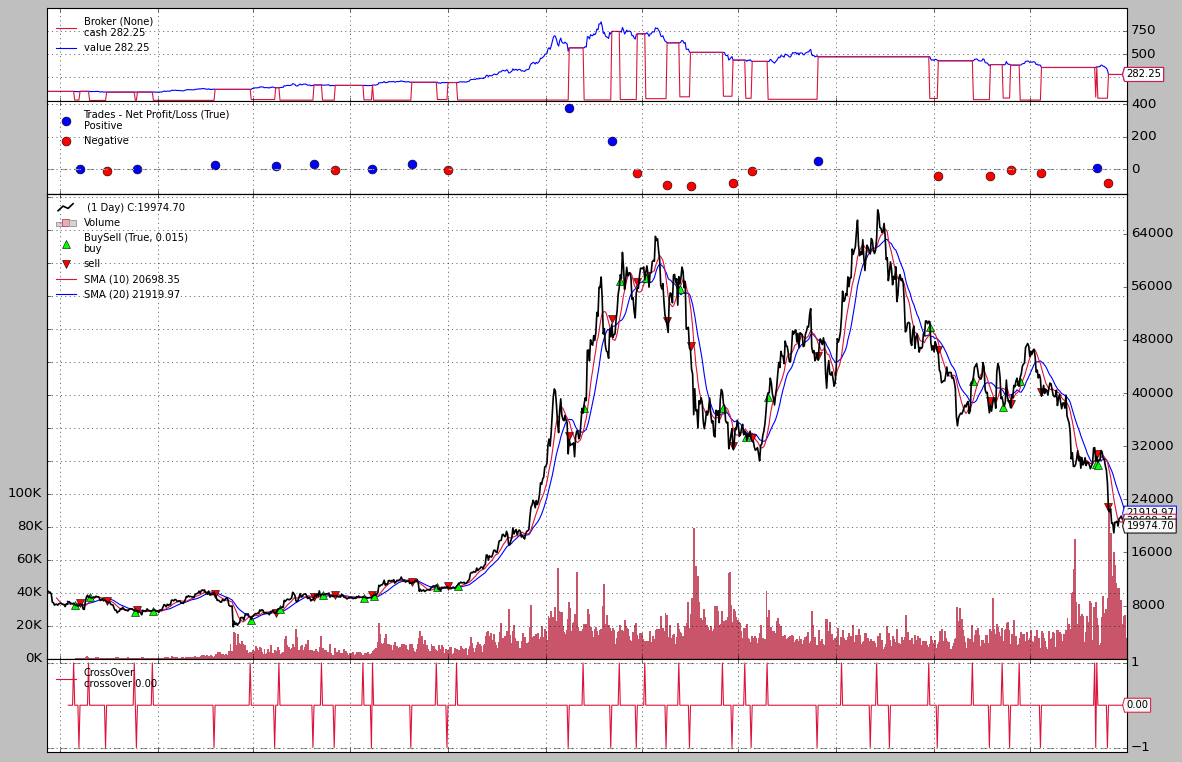

In [28]:
cerebro = bt.Cerebro()
cerebro.addstrategy(smaCro)

cerebro.adddata(bt.feeds.PandasData(dataname = price_btc[['Close', 'Volume']].iloc[:],\
     close='Close', volume='Volume', open='Close', high='Close', low='Close'))

cerebro.broker.set_cash(100)
cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

print('Starting Portfolio Value: %.2f' % cerebro.broker.get_value())
cerebro.run()
cerebro.plot()
print('Final Portfolio Value: %.2f' % cerebro.broker.get_value())

In [40]:
class BuyAndHold_1(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash())
        self.buy()

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

Starting Portfolio Value: 100.00
100
ROI:        95.60%


<IPython.core.display.Javascript object>

Final Portfolio Value: 195.60


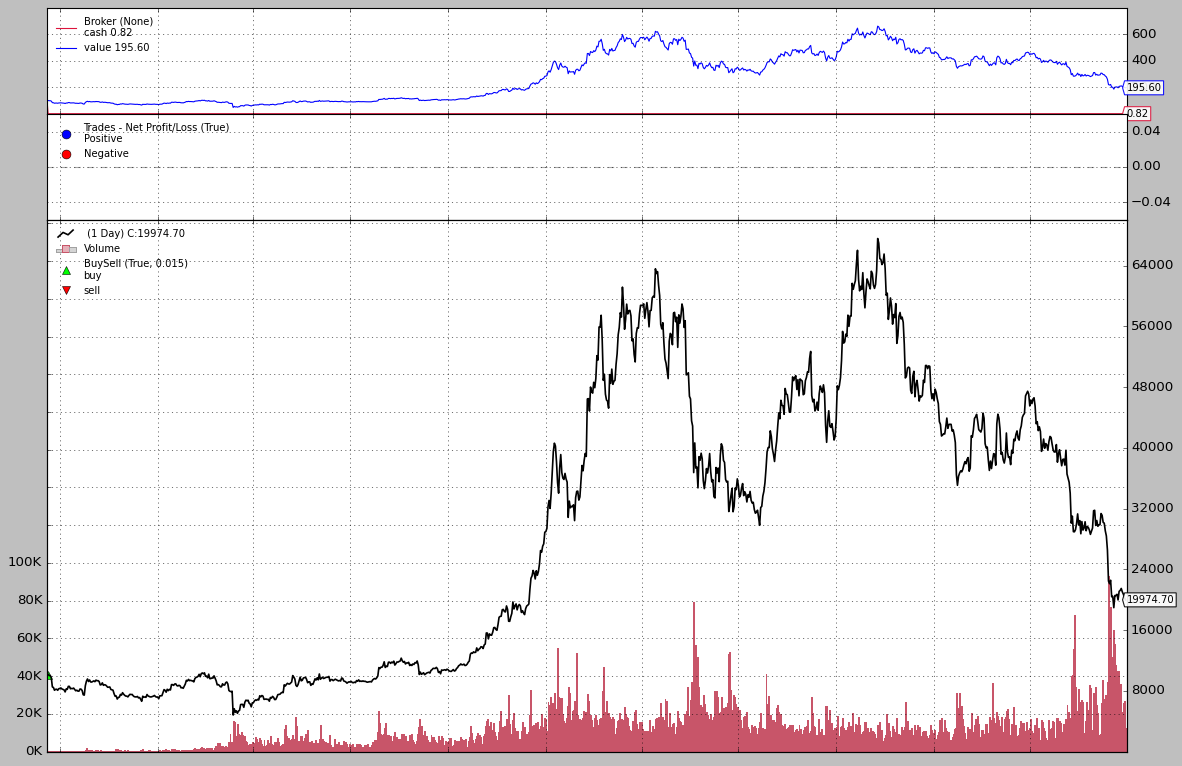

In [56]:
cerebroH = bt.Cerebro()
cerebroH.addstrategy(BuyAndHold_1)

cerebroH.adddata(bt.feeds.PandasData(dataname = price_btc[['Close', 'Volume']].iloc[:],\
     close='Close', volume='Volume', open='Close', high='Close', low='Close'))

cerebroH.broker.set_cash(100)
cerebroH.addsizer(bt.sizers.PercentSizer, percents=100)

print('Starting Portfolio Value: %.2f' % cerebroH.broker.get_value())
cerebroH.run()
cerebroH.plot()
print('Final Portfolio Value: %.2f' % cerebroH.broker.get_value())